In [2]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import torch
import torch.nn as nn

In [3]:
# Define a neural network
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        out = self.net(x)
        return out


In [4]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # comp. domain 
        self.h = 0.1#step size of x
        self.k = 0.1#step size of t
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
    
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [5]:
# training
net = Net()
net.train()

c:\Users\MOBIT\anaconda3\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.187567338347435
200 0.09621057659387589
300 0.08279361575841904
400 0.06393421441316605
500 0.039931342005729675
600 0.024910366162657738
700 0.02062172070145607
800 0.019881106913089752
900 0.014974117279052734
1000 0.013252099975943565
1100 0.007464233785867691
1200 0.004308153409510851
1300 0.0023084538988769054
1400 0.0016824875492602587
1500 0.0012266901321709156
1600 0.0009777880040928721
1700 0.000698985590133816
1800 0.000592612661421299
1900 0.0005120036657899618
2000 0.00046100077452138066
2100 0.00039033842040225863
2200 0.00033077620901167393
2300 0.00029078900115564466
2400 0.00026666512712836266
2500 0.0002479781396687031
2600 0.00022843657643534243
2700 0.00021658791229128838
2800 0.00018623349023982882
2900 0.00017216423293575644
3000 0.000155369532876648
3100 0.00013794034020975232
3200 0.0001306565391132608
3300 0.00012104838970117271
3400 0.00010897133324760944
3500 0.00010281200957251713
3600 9.424539166502655e-05
3700 8.371604781132191e-05
3800 7.799359445925

In [6]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [8]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [9]:
y_pred.shape

(200, 100)

In [10]:
y_pred

array([[ 0.00276496,  0.00235738,  0.00199171, ..., -0.0012884 ,
        -0.0012453 , -0.0012    ],
       [ 0.03429895,  0.03294371,  0.03168036, ...,  0.00624939,
         0.00622912,  0.00621204],
       [ 0.06566946,  0.06337814,  0.06122746, ...,  0.01380282,
         0.01371931,  0.0136398 ],
       ...,
       [-0.09303229, -0.09045278, -0.08806698, ..., -0.02475474,
        -0.02458156, -0.02441351],
       [-0.06154184, -0.0598941 , -0.05839158, ..., -0.01676543,
        -0.01665429, -0.0165479 ],
       [-0.02987311, -0.02916665, -0.02855681, ..., -0.0087616 ,
        -0.00871263, -0.00866766]], dtype=float32)

In [11]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

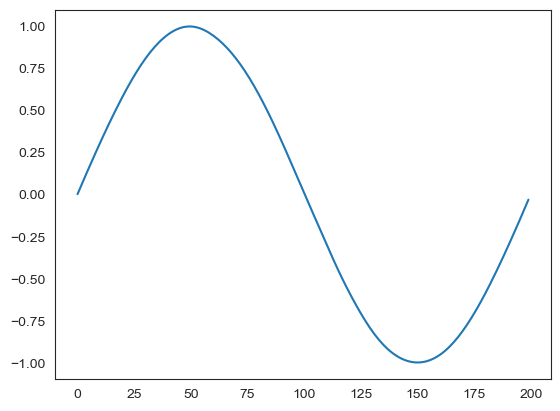

In [12]:
plt.plot(y_pred[:,0])

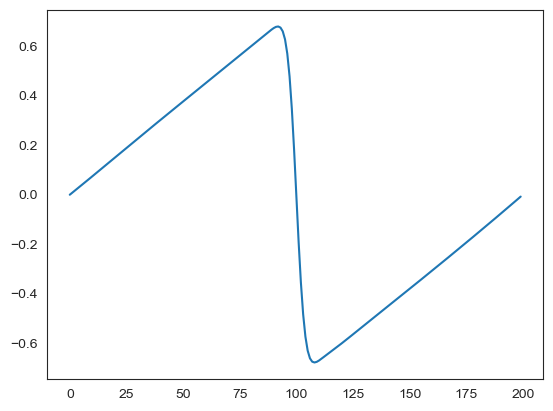

In [13]:
plt.plot(y_pred[:,-1])

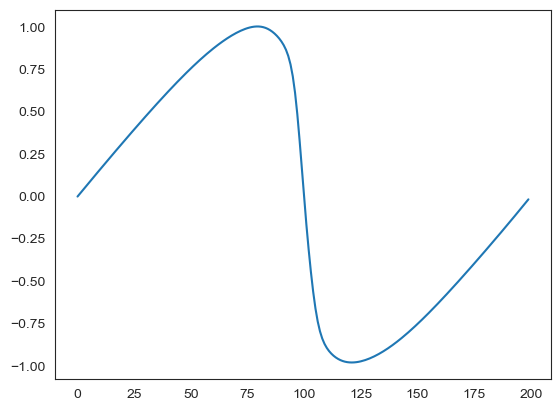

In [14]:
plt.plot(y_pred[:,30])